# Description

It generates datasets showing different relationship types between pairs of variables (for instance, a linear or quadratic pattern) and then compares different correlation coefficients.

# Modules

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale

from clustermatch import conf
from clustermatch.coef import cm

# Settings

# Paths

In [2]:
assert (
    conf.MANUSCRIPT["BASE_DIR"] is not None and conf.MANUSCRIPT["BASE_DIR"].exists()
), "Manuscript dir not set"

In [3]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "intro"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/intro')

# Generate datasets

## Anscombe dataset

In [4]:
datasets_df = sns.load_dataset("anscombe")

In [5]:
datasets_df.shape

(44, 3)

In [6]:
datasets_df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [7]:
datasets_df = datasets_df.assign(
    dataset=datasets_df["dataset"].apply(lambda x: f"Anscombe {x}")
)

In [8]:
datasets_df.describe()

,x,y
count,44.000000,44.000000
mean,9.000000,7.500682
std,3.198837,1.958925
min,4.000000,3.100000
25%,7.000000,6.117500
50%,8.000000,7.520000
75%,11.000000,8.747500
max,19.000000,12.740000


In [9]:
x_lim = (3, 20)
y_lim = (3, 13)

## Quadratic

In [10]:
rel_name = "Quadratic"

In [11]:
np.random.seed(0)

x = minmax_scale(np.random.rand(100), (-10, 10))
y = np.power(x, 2.0)

x = minmax_scale(x, (0, x_lim[1]))
x = x + np.random.normal(0, 0.5, x.shape[0])
y = minmax_scale(y, y_lim)
y = y + np.random.normal(0, 0.5, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": rel_name,
            "x": x,
            "y": y,
        }
    ),
    ignore_index=True,
)

## Non-coexistence

In [12]:
rel_name = "Non-coexistence"

In [13]:
np.random.seed(5)

# x = minmax_scale(np.random.beta(0.5, 0.5, 50), (0.05, 20))
# y = np.power(0.05, x) # np.log(x) / np.log(1/10.)

x = minmax_scale(np.random.rand(50), (0, x_lim[1]))
y = minmax_scale(np.random.rand(50), (2, 2 + 0.5))

x2 = minmax_scale(np.random.rand(50), (0, 0 + 0.5))
y2 = minmax_scale(np.random.rand(50), (2, y_lim[1]))
x = np.append(x, x2)
y = np.append(y, y2)

# x = minmax_scale(x, (0, 20))
x = x + np.random.normal(0, 0.05, x.shape[0])
# y = minmax_scale(y, (3, 12))
y = y + np.random.normal(0, 0.05, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": rel_name,
            "x": x,
            "y": y,
        }
    ),
    ignore_index=True,
)

## Two lines

In [14]:
rel_name = "Two lines"

In [15]:
np.random.seed(5)

x = minmax_scale(np.random.rand(50), x_lim)
y = 0.3 * x

x2 = minmax_scale(np.random.rand(50), (0, 5))
y2 = 3.5 * x2
x = np.append(x, x2)
y = np.append(y, y2)

# x = minmax_scale(x, (0, 20))
x = x + np.random.normal(0, 0.5, x.shape[0])
y = minmax_scale(y, y_lim)
y = y + np.random.normal(0, 0.5, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": rel_name,
            "x": x,
            "y": y,
        }
    ),
    ignore_index=True,
)

## Random / independent

In [16]:
rel_name = "Random/independent"

In [17]:
np.random.seed(10)

x = np.random.rand(100)
y = np.random.rand(100)

x = minmax_scale(x, (0, x_lim[1]))
y = minmax_scale(y, y_lim)

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = datasets_df.append(
    pd.DataFrame(
        {
            "dataset": rel_name,
            "x": x,
            "y": y,
        }
    ),
    ignore_index=True,
)

Create a dictionary with easier access to datasets

In [18]:
datasets = {
    idx: df.drop(columns="dataset") for idx, df in datasets_df.groupby("dataset")
}

# Plot

In [19]:
def get_cm_line_points(x, y, max_parts, parts):
    """
    Given two data vectors (x and y) and the max_parts and parts
    returned from calling cm, this function returns two arrays with
    scalars to draw the lines that separates clusters in x and y.
    """
    # get the clustermatch partitions that maximize the coefficient
    x_max_part = parts[0][max_parts[0]]
    x_unique_k = {}
    for k in np.unique(x_max_part):
        data = x[x_max_part == k]
        x_unique_k[k] = data.min(), data.max()
    x_unique_k = sorted(x_unique_k.items(), key=lambda x: x[1][0])

    y_max_part = parts[1][max_parts[1]]
    y_unique_k = {}
    for k in np.unique(y_max_part):
        data = y[y_max_part == k]
        y_unique_k[k] = data.min(), data.max()
    y_unique_k = sorted(y_unique_k.items(), key=lambda x: x[1][0])

    x_line_points, y_line_points = [], []

    for idx in range(len(x_unique_k) - 1):
        k, (k_min, k_max) = x_unique_k[idx]
        nk, (nk_min, nk_max) = x_unique_k[idx + 1]

        x_line_points.append((k_max + nk_min) / 2.0)

    for idx in range(len(y_unique_k) - 1):
        k, (k_min, k_max) = y_unique_k[idx]
        nk, (nk_min, nk_max) = y_unique_k[idx + 1]

        y_line_points.append((k_max + nk_min) / 2.0)

    return x_line_points, y_line_points

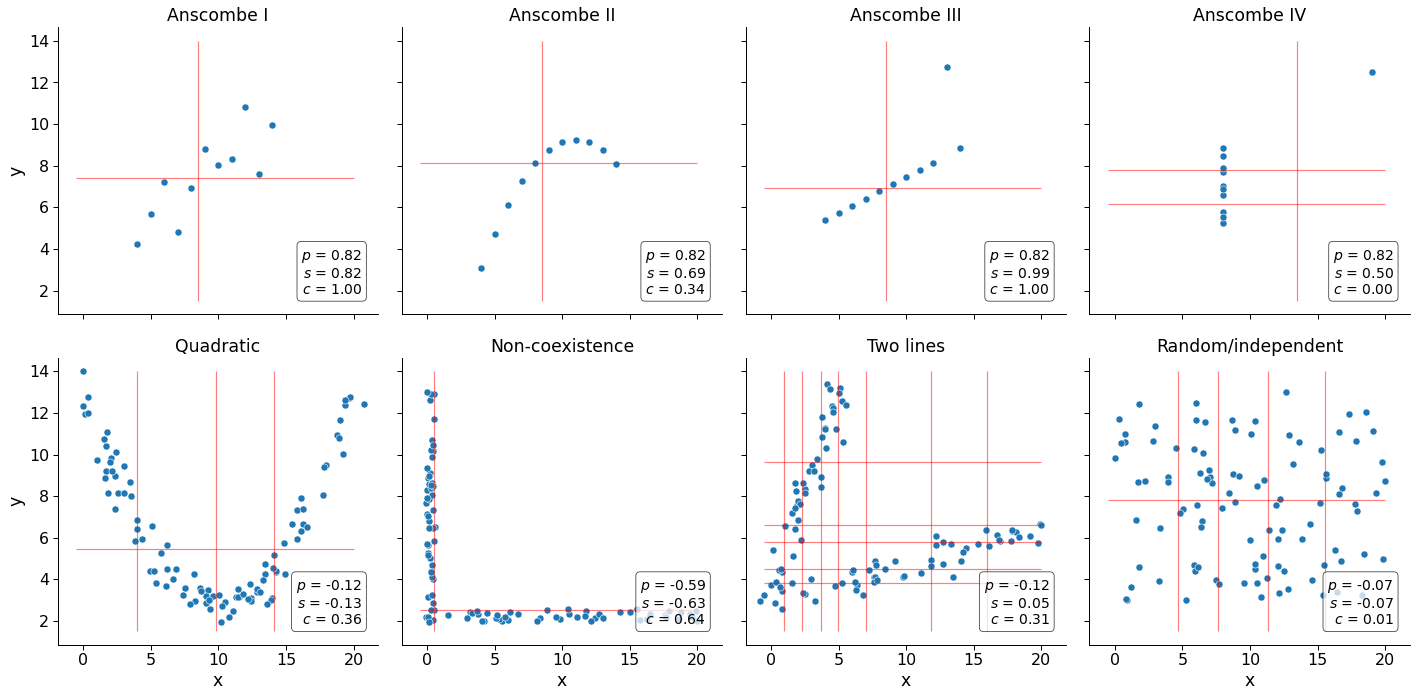

In [20]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(data=datasets_df, col="dataset", col_wrap=4, height=5)
    g.map(sns.scatterplot, "x", "y", s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r = pearsonr(x, y)[0]
        rs = spearmanr(x, y)[0]

        # clustermatch
        c, max_parts, parts = cm(x, y, return_parts=True)
        c = cm(x, y)

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=-0.5, xmax=20, color="r", alpha=0.5)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=1.5, ymax=14, color="r", alpha=0.5)

        # add text box for the statistics
        stats = f"$p$ = {r:.2f}\n" f"$s$ = {rs:.2f}\n" f"$c$ = {c:.2f}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.95,
            0.07,
            stats,
            fontsize=14,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="right",
        )

    plt.savefig(
        OUTPUT_FIGURE_DIR / "relationships.svg",
        # rasterized=True,
        # dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

**Takeaways**:

A more detailed explanation of this figure is present in this PR: https://github.com/greenelab/clustermatch-gene-expr-manuscript/pull/3

Some points:

1. When the number of internal clusters (separated by red lines) is higher, Clustermatch is able to capture more complex relationships.
1. With two internal clusters (Anscombe I, II and III) for each variable pair, Clustermatch seems to capture linear relationships. However, two clusters also capture non-coexistence relationships.